# AMS paper claims that...

ADAM iterates $x_t$ converge to x = 1, which unfortunately has the largest regret amongst all points in the domain. On the other hand, the average regret of AMSGRAD converges to 0 and its iterate converges to the optimal solution.

\begin{equation}
  f_t(x)=\begin{cases}
    1010x, & \text{with probability 0.01}\\
    -10x, & \text{otherwise}.
  \end{cases}
\end{equation}

where $x=[-1, 1]$.


Lets verify if it's true.

In [154]:
import torch
import numpy as np
import matplotlib.pylab as plt
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

# First, Let's implement ADAM from scratch


In [168]:
import math
from torch.optim import Optimizer

class ADAMOptimizer(Optimizer):
    """
    implements ADAM Algorithm, as a preceding step.
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(ADAMOptimizer, self).__init__(params, defaults)
        
    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:
            #print (self.param_groups[0]['params'][0].size()), First param (W) size: torch.Size([10, 784])
            #print (self.param_groups[0]['params'][1].size()), Second param(b) size: torch.Size([10])
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Momentum (Exponential MA of gradients)
                    state['exp_avg'] = torch.zeros_like(p.data)
                    #print(p.data.size())
                    # RMS Prop componenet. (Exponential MA of squared gradients). Denominator.
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2 penalty. Gotta add to Gradient as well.
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 
                
                if state['step']  % 10000 ==0:
                    print ("group:", group)
                    print("p: ",p)
                    print("p.data: ", p.data) # W = p.data
                
        return loss


# Second, Implement AMS on top of ADAM

# Testing both ADAM & AMS on simple Logistic Regression

In [190]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters as stated in the paper - https://openreview.net/forum?id=ryQu7f-RZ
input_size = 784
num_classes = 10
num_epochs = 5
batch_size = 128
learning_rate = 0.001

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Logistic regression model
model = nn.Linear(input_size, num_classes)

# Loss: nn.CrossEntropyLoss() computes softmax internally
criterion = nn.CrossEntropyLoss()  

# Adam
optimizer = ADAMOptimizer(model.parameters(), lr=learning_rate)  
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0) # To double check the implementation

In [191]:
model.parameters

<bound method Module.parameters of Linear(in_features=784, out_features=10, bias=True)>

In [192]:
len(train_loader)

469

In [193]:
# Train the model

total_step = len(train_loader)
adam_loss_list = []

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, 28*28)
        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)
        adam_loss_list.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, batch_idx+1, total_step, loss.item()))


Epoch [1/5], Step [1/469], Loss: 2.3241
Epoch [1/5], Step [101/469], Loss: 0.8930
Epoch [1/5], Step [201/469], Loss: 0.4822
Epoch [1/5], Step [301/469], Loss: 0.4837
Epoch [1/5], Step [401/469], Loss: 0.3685
Epoch [2/5], Step [1/469], Loss: 0.4409
Epoch [2/5], Step [101/469], Loss: 0.4088
Epoch [2/5], Step [201/469], Loss: 0.4610
Epoch [2/5], Step [301/469], Loss: 0.3673
Epoch [2/5], Step [401/469], Loss: 0.2353
Epoch [3/5], Step [1/469], Loss: 0.4252
Epoch [3/5], Step [101/469], Loss: 0.3476
Epoch [3/5], Step [201/469], Loss: 0.5284
Epoch [3/5], Step [301/469], Loss: 0.4335
Epoch [3/5], Step [401/469], Loss: 0.2737
Epoch [4/5], Step [1/469], Loss: 0.3128
Epoch [4/5], Step [101/469], Loss: 0.3986
Epoch [4/5], Step [201/469], Loss: 0.2595
Epoch [4/5], Step [301/469], Loss: 0.3329
Epoch [4/5], Step [401/469], Loss: 0.2046
Epoch [5/5], Step [1/469], Loss: 0.5740
Epoch [5/5], Step [101/469], Loss: 0.4283
Epoch [5/5], Step [201/469], Loss: 0.3684
Epoch [5/5], Step [301/469], Loss: 0.6881
Ep

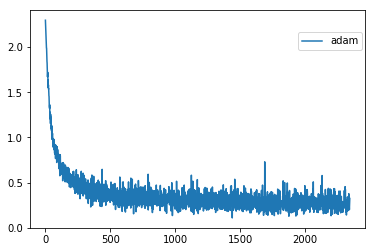

In [189]:
plt.plot(adam_loss_list, label="adam")
#plt.plot(results_amsgrad, label="amsgrad")
plt.legend(bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.)
#plt.savefig("fig1.png")
plt.show()

In [161]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the model on the 10000 test images: 91 %


# Testing on Synthetic experiment

In [39]:
x_max = Variable(torch.Tensor([1.0]), requires_grad=True)
x_min = Variable(torch.Tensor([-1.0]), requires_grad=True)

def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

def domain_constraints(x):
    if x > 1.0:
        return x_max
    if x < -1.0:
        return x_min
    return x


def OnlineLearning(learning_rate=1e-3, amsgrad=False):
    x = Variable(torch.Tensor([0.5]), requires_grad=True)
    optimizer = ADAMOptimizer([x], lr=learning_rate, betas=(0.9, 0.99), eps=1e-8)

    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []

    for step in range(1,1000001):
        x = domain_constraints(x)
        loss = online_f_t(x, step)
        # This is how the regret is defined in this paper.
        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum/step
    
        optimizer.zero_grad()
        # calculate gradients
        loss.backward()
        """
        if step%10000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
            x_history.append(x.item())
            print ('step : ',step,  '  x : ',x, '  loss : ',loss, '   regret_sum : ',regret_sum, ' regret_avg : ',regret_avg )
            print (x.grad)
        """
        optimizer.step()   
    return time_steps, avg_regret_history, x_history


In [40]:
lr = 1e-1
# AMSGrad
time_steps, avg_regret_history, x_history = OnlineLearning(learning_rate=lr)


group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps': 1e-08, 'weight_decay': 0}
p:  tensor([ 1.0365])
p.data:  tensor([ 1.0365])
group: {'params': [tensor([ 1.0365])], 'lr': 0.1, 'betas': (0.9, 0.99), 'eps

KeyboardInterrupt: 